<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/llama2/Llama3_8b_CoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meta-Llama-3-8B-Instruct

Meta developed and released the Meta Llama 3 family of large language models (LLMs), a collection of pretrained and instruction tuned generative text models in 8 and 70B sizes. The Llama 3 instruction tuned models are optimized for dialogue use cases and outperform many of the available open source chat models on common industry benchmarks. Further, in developing these models, we took great care to optimize helpfulness and safety.



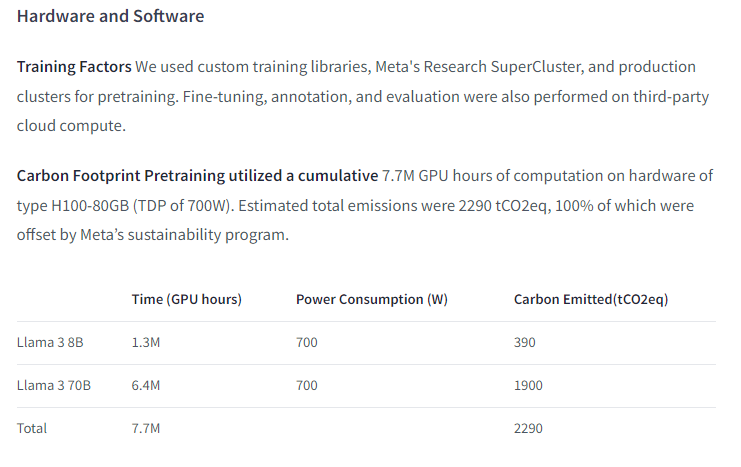

That's 5.4GWh. That's 6 hours of an entire nuclear reactor.
Anualy a Nuclear Reactor produce in average 8500 GigaWatt

In [ ]:
!pip install torch accelerate bitsandbytes datasets transformers peft trl scipy  wandb -q

#### HuggingFace URI
meta-llama/Meta-Llama-3-8B

In [ ]:
import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
from torch import cuda, bfloat16
import transformers

import torch
import torch.nn as nn

In [ ]:
transformers.__version__

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


# Llama3 8B
https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct



In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)


In [ ]:
memory_used = model.get_memory_footprint()
print("Memory footprint: {} GB".format(memory_used/1024/1024/1024))

In [ ]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

In [ ]:
tst = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.

['i', 'P', 'h', '849', 'e']

RESPONSE:
</INST>"""

In [ ]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst},
]

EXPECTED ANSWER:

### RESPONSE:
The given list ['i', 'P', 'h', '849', 'e'] contains the number 849, which is the only element of the list that is a number. Therefore, the final answer is 849.

Therefore the answer is 849

### End

In [ ]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

In [ ]:
tst_2 = """<INST>  Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman.
Then I went again and bought 5 more apples and I ate 1 apple.
Answer: How many apples did I remain with?

### RESPONSE:
</INST>"""

'''
EXPECTED ANSWER:

### RESPONSE:
1. You bought 10 apples and gave 2 to your neighbor and 2 to your repairman, leaving you with 10 - 2 - 2 = 6 apples.
2. Then you bought 5 more apples, adding 6 to 5 = 11 apples.
3. Finally, you ate 1 apple, leaving you with 11 - 1 = 10 apples.

### End'''

In [ ]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_2},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

In [ ]:
tst_3 = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
When I was 6, my sister was half of my age. Now I’m 70 years old.
Answer how old is my sister now?

### RESPONSE:
</INST>"""

# Expected response

67 years old

In [ ]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_3},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

In [ ]:
tst_4 = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
Question: I had a car 20 years ago and at that time I was 37. Answer: How old I am now?

### RESPONSE:
</INST>"""

# Response expected 57 years old

In [ ]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_4},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

In [ ]:
tst_5 = """<INST>Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I had a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?

### RESPONSE:
</INST>"""

In [ ]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_5},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

In [ ]:
tst_5b = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I bought a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?
Let,s think step by step

### RESPONSE:
</INST>"""

In [ ]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_5b},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.9,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

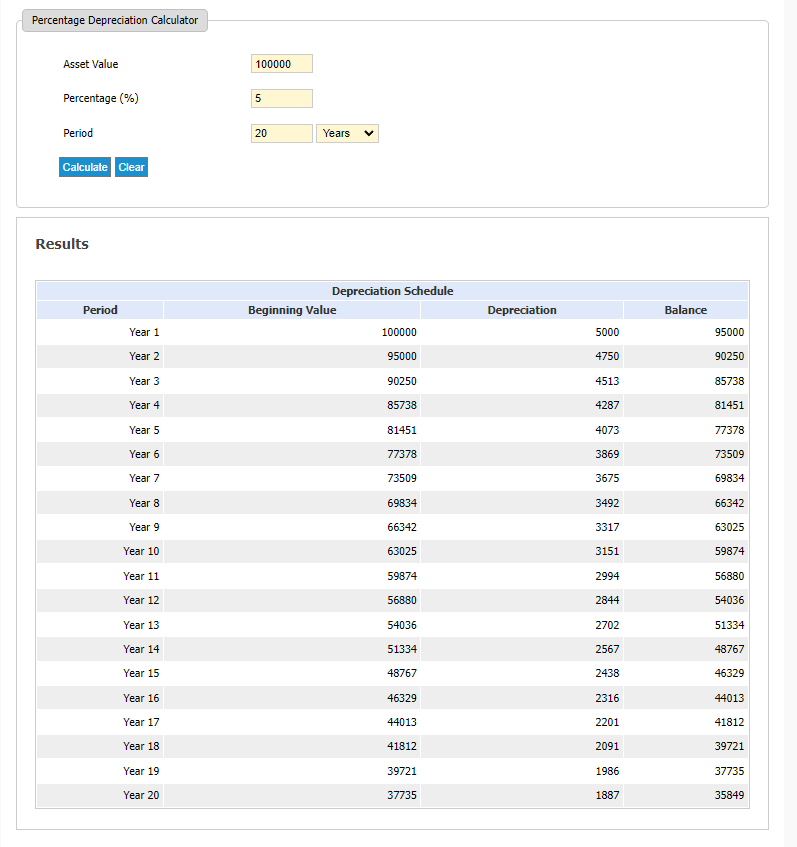